In [2]:
!brew install libomp

To reinstall 14.0.6, run:
  brew reinstall libomp


In [3]:
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(plt.rcParams['font.family'])

['sans-serif']


## 都道府県を全て結合してデータ読み込み

In [2]:
import glob

train_files = glob.glob('./data/train/*.csv')
train = pd.DataFrame()
for file in train_files:
    train1 = pd.read_csv(file)
    cat_train = pd.concat([train,train1])
    train = cat_train
    


/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/4259370092.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/4259370092.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/4259370092.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/4259370092.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train1 = pd.read_csv(file)


## 欠損値の多いカラムを削除するクラス

In [3]:
class Delete_Null_Data():
    """
    欠損率が高いcolumnを削除するclass
    """
    
    def __init__(self,df):
        self.df = df
        
    #nullのカウントとnullの%のDataframeを返すメソッド
    def null_counts(self):
        null_counts_df = self.df
        null_counts_df = pd.DataFrame(null_counts_df.isnull().sum(),columns=['null_counts'])
        null_counts_df['null_par'] = null_counts_df['null_counts']/len(self.df)
        return null_counts_df
    
    #nullの多いcolumnを削除するメソッド引数にnullの%を指定　１００％→１　５０％→0.5
    def delete_null_columns(self,null_par=0.9):
        df = self.null_counts()
        re_df = df[df['null_par']>null_par]
        cols = re_df.index.tolist()
        delete_df = self.df.drop(labels=cols,axis=1)
        
        return delete_df

In [4]:
#欠損値の多い列の削除
Adj_Data=Delete_Null_Data(train)
train=Adj_Data.delete_null_columns()
train.shape

(722574, 20)

In [5]:
train.columns

Index(['ID', '種類', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '間取り', '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引価格（総額）_log'],
      dtype='object')

In [6]:
train=train[['都道府県名','市区町村名','面積（㎡）','建築年','取引価格（総額）_log']]
train.columns

Index(['都道府県名', '市区町村名', '面積（㎡）', '建築年', '取引価格（総額）_log'], dtype='object')

In [7]:
train.shape

(722574, 5)

## 建築年のデータ加工

In [8]:
## 建築年数を返すメソッド
import numpy as np

class Constructed_year():
    def __init__(self, df):
        self.df=df['建築年']
    
    #年号表記の年を西暦に変換するメソッド
    def seireki(self):
        l=[]
        
        for i in range(len(self.df)):
            #平成〇〇年から西暦に変換
            if self.df.iloc[i][:2]=='平成':
                if self.df.iloc[i][3]=='年':
                    year=1988+int(self.df.iloc[i][2])
                else:
                    year=1988+int(self.df.iloc[i][2])*10+int(self.df.iloc[i][3]) 
                l.append(year)
                
            #昭和〇〇年から西暦に変換
            if self.df.iloc[i][:2]=='昭和':
                if self.df.iloc[i][3]=='年':
                    year=1925+int(self.df.iloc[i][2])
                else:
                    year=1925+int(self.df.iloc[i][2])*10+int(self.df.iloc[i][3]) 
                l.append(year)
                
            #令和〇〇年から西暦に変換
            if self.df.iloc[i][:2]=='令和':
                if self.df.iloc[i][3]=='年':
                    year=2018+int(self.df.iloc[i][2])
                else:
                    year=2018+int(self.df.iloc[i][2])*10+int(self.df.iloc[i][3]) 
                l.append(year)
                
            #戦前は1945年に変換
            if self.df.iloc[i][:2]=='戦前':
                year=1945
                l.append(int(year))
                
            #欠損値がある時    
            if len(self.df.iloc[i])==0:
                l.append(int(np.mean(l)))
        return l


In [9]:
#データの量が多いので建築年ごとに西暦変換処理
reiwa=train[train['建築年'].str.contains('令和')==True]
heisei=train[train['建築年'].str.contains('平成')==True]
syouwa=train[train['建築年'].str.contains('昭和')==True]
sennzenn=train[train['建築年'].str.contains('戦前')==True]

print('令和', reiwa.shape)
print('平成', heisei.shape)
print('昭和', syouwa.shape)
print('戦前', sennzenn.shape)


令和 (1622, 5)
平成 (487868, 5)
昭和 (211525, 5)
戦前 (578, 5)


In [10]:
#インスタンス化、変換した西暦をカラムとして扱う
_reiwa=Constructed_year(reiwa)
_heisei=Constructed_year(heisei)
_syouwa=Constructed_year(syouwa)
_sennzenn=Constructed_year(sennzenn)

reiwa['建築年']=_reiwa.seireki()
heisei['建築年']=_heisei.seireki()
syouwa['建築年']=_syouwa.seireki()
sennzenn['建築年']=_sennzenn.seireki()



/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/808375370.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reiwa['建築年']=_reiwa.seireki()
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/808375370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heisei['建築年']=_heisei.seireki()
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/808375370.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [11]:
sennzenn.tail()

,都道府県名,市区町村名,面積（㎡）,建築年,取引価格（総額）_log
32068,千葉県,千葉市美浜区,60,1945,7.447158
32142,千葉県,千葉市中央区,70,1945,7.278754
32674,千葉県,千葉市若葉区,65,1945,6.851258
32955,千葉県,市原市,70,1945,6.041393
35154,千葉県,我孫子市,70,1945,7.230449


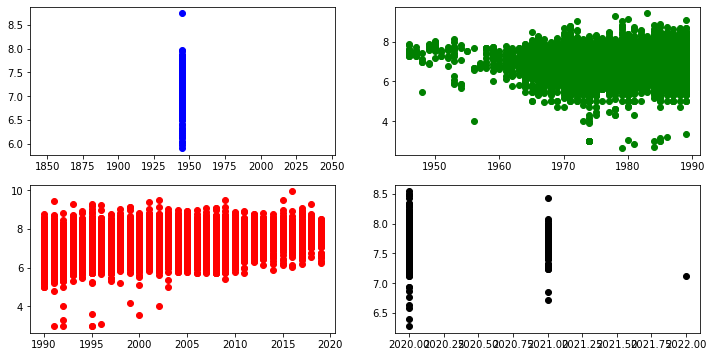

In [12]:
#築年数と価格の関係
mean1=sennzenn.groupby('建築年').mean()
mean2=syouwa.groupby('建築年').mean()
mean3=heisei.groupby('建築年').mean()
mean4=reiwa.groupby('建築年').mean()


fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

c1,c2,c3,c4 = "blue","green","red","black"      # 各プロットの色
l1,l2,l3,l4 = "戦前","昭和","平成","令和"   # 各ラベル

"""
ax1.bar(sennzenn['建築年'].unique(), mean1['取引価格（総額）_log'], color=c1, label=l1)
ax2.bar(syouwa['建築年'].unique(), mean2['取引価格（総額）_log'], color=c2, label=l2)
ax3.bar(heisei['建築年'].unique(), mean3['取引価格（総額）_log'], color=c3, label=l3)
ax4.bar(reiwa['建築年'].unique(), mean4['取引価格（総額）_log'], color=c4, label=l4)

"""


ax1.scatter(sennzenn['建築年'], sennzenn['取引価格（総額）_log'], color=c1, label=l1)
ax2.scatter(syouwa['建築年'], syouwa['取引価格（総額）_log'], color=c2, label=l2)
ax3.scatter(heisei['建築年'], heisei['取引価格（総額）_log'], color=c3, label=l3)
ax4.scatter(reiwa['建築年'], reiwa['取引価格（総額）_log'], color=c4, label=l4)


plt.show()

## 面積のデータ加工

In [13]:
syouwa1=syouwa
syouwa1['面積（㎡）'].unique()

array(['45', '15', '80', '60', '40', '55', '70', '30', '75', '25', '65',
       '90', '20', '105', '35', '50', '85', '160', '100', '95', '110',
       '230', '180', '290', '115', '10', '210', '140', '145', '150',
       '130', '135', '200', '170', '120', '155', '260', '480', '360',
       '125', '740', 20, 70, 65, 10, 60, 55, 25, 80, 45, 35, 50, 30, 75,
       15, 95, 110, 40, 85, 90, 120, 145, 280, 115, 105, 100, 195, '470',
       '710', 125, 160, 230, 180, 175, 480, 155, 300, 130, 170, 140, 150,
       135, 410, 165, 970, '165', '2000㎡以上', '590', '185', '410', '190',
       '660', '320', '240', '760', '830', '670', '220', '300', '340',
       '175', '500', '460', 210, 220, 500, 1100, 700, 185, 450, 490, 260,
       440, 430, 350, 270, 290, 390, 240, 370, 650, 460, 250, 510, 190,
       360, 200, 590, 660, 960, 380, '520', '250', '310', 470, 1400, 320,
       740, 310, 420, '1000', '690', '280', '440', '370', '380', 990, 720,
       680, 340, 1000], dtype=object)

In [14]:
syouwa1.loc[4476,'面積（㎡）'] = '2000'
syouwa1.loc[15900,'面積（㎡）'] = '2000'
syouwa1.loc[24246,'面積（㎡）'] = '2000'
syouwa1.loc[618,'面積（㎡）'] = '2000'

In [15]:
heisei[heisei['面積（㎡）']=='2000㎡以上']
heisei.loc[12787,'面積（㎡）'] = '2000'
heisei.loc[111,'面積（㎡）'] = '2000'
heisei.loc[13121,'面積（㎡）'] = '2000'
heisei.loc[1144,'面積（㎡）'] = '2000'
heisei.loc[18170,'面積（㎡）'] = '2000'

In [16]:
sennzenn['面積（㎡）']=sennzenn['面積（㎡）'].astype('int')
syouwa['面積（㎡）']=syouwa['面積（㎡）'].astype('int')
heisei['面積（㎡）']=heisei['面積（㎡）'].astype('int')
reiwa['面積（㎡）']=reiwa['面積（㎡）'].astype('int')

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/3462841023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sennzenn['面積（㎡）']=sennzenn['面積（㎡）'].astype('int')
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/3462841023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syouwa['面積（㎡）']=syouwa['面積（㎡）'].astype('int')
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/3462841023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [17]:
#reiwa['面積（㎡）'].astype('int')

reiwa['面積（㎡）'].dtype

dtype('int64')

In [ ]:
## 昭和データで目的変数

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIG

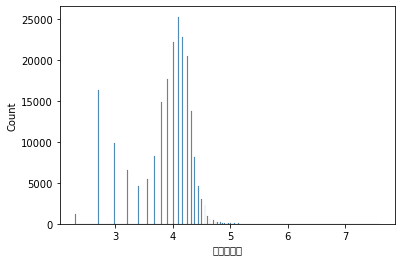

In [22]:
#昭和のデータ
sns.histplot(np.log(syouwa['面積（㎡）']))

plt.show()
# plt.scatter(np.log(syouwa['面積（㎡）']), syouwa['取引価格（総額）_log'])

In [30]:
syouwa['面積_log']=np.log(syouwa['面積（㎡）'])
syouwa['価格/面積_log']=syouwa['取引価格（総額）_log']-syouwa['面積_log']
# mean_log=np.mean(syouwa['価格/面積_log'])
mean_log=syouwa['価格/面積_log']

syouwa['価格_理論値']=mean_log*syouwa['価格/面積_log']
syouwa['理論値-真値']=syouwa['取引価格（総額）_log']-syouwa['価格_理論値']
syouwa

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/1330087949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syouwa['面積_log']=np.log(syouwa['面積（㎡）'])
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/1330087949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syouwa['価格/面積_log']=syouwa['取引価格（総額）_log']-syouwa['面積_log']
/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_9921/1330087949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,都道府県名,市区町村名,面積（㎡）,建築年,取引価格（総額）_log,面積_log,価格/面積_log,価格_理論値,理論値-真値
0,福岡県,福岡市中央区,45,1988,7.041393,3.806662,3.234730,10.463479,-3.422087
1,福岡県,福岡市早良区,15,1989,6.602060,2.708050,3.894010,15.163312,-8.561252
2,福岡県,福岡市早良区,80,1988,7.397940,4.382027,3.015913,9.095733,-1.697793
4,福岡県,福岡市中央区,60,1987,6.929419,4.094345,2.835074,8.037647,-1.108228
9,福岡県,福岡市博多区,40,1987,6.869232,3.688879,3.180352,10.114641,-3.245409
...,...,...,...,...,...,...,...,...,...
37361,千葉県,印西市,55,1984,6.724276,4.007333,2.716943,7.381778,-0.657502
37372,千葉県,千葉市美浜区,45,1968,6.602060,3.806662,2.795398,7.814247,-1.212187
37374,千葉県,市川市,70,1980,7.342423,4.248495,3.093927,9.572387,-2.229964
37377,千葉県,船橋市,45,1968,6.770852,3.806662,2.964190,8.786420,-2.015568


<AxesSubplot:xlabel='面積（㎡）', ylabel='Count'>

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 13217 (\N{SQUARE M SQUARED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIG

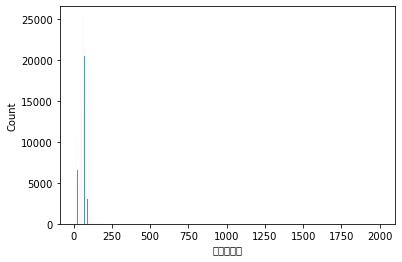

In [23]:
sns.histplot(syouwa['面積（㎡）'])

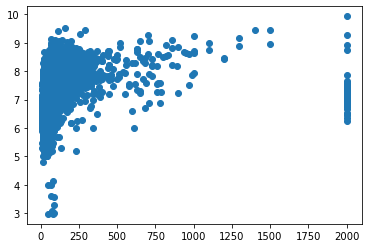

In [19]:
#平成のデータ
plt.scatter(heisei['面積（㎡）'], heisei['取引価格（総額）_log'])

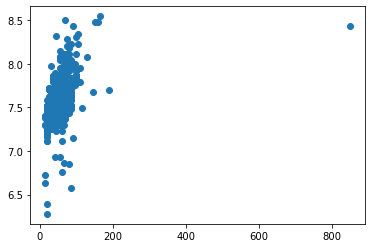

In [20]:
#令和のデータ
plt.scatter(reiwa['面積（㎡）'], reiwa['取引価格（総額）_log'])

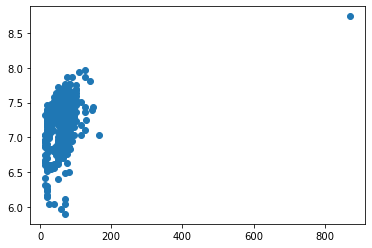

In [21]:
#戦前のデータ
plt.scatter(sennzenn['面積（㎡）'], sennzenn['取引価格（総額）_log'])

In [22]:
reiwa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1622 entries, 1032 to 33167
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   都道府県名         1622 non-null   object 
 1   市区町村名         1622 non-null   object 
 2   面積（㎡）         1622 non-null   int64  
 3   建築年           1622 non-null   int64  
 4   取引価格（総額）_log  1622 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 76.0+ KB


## 都道府県、市区町村のデータ加工
- 都市部、地方都市、過疎地域 
-人口100万以上は大都市 
-人口20万以上100万未満は地方都市
-過疎地域は20万以下

In [23]:
#建築年ごとに分割したデータを結合して訓練用データとして扱う
train_all=pd.concat([sennzenn,syouwa,heisei,reiwa])

In [24]:
train_all.shape

(701593, 5)

In [25]:
print(train_all.columns)
print('---------------------------------------------------------')
print(train_all.info())

Index(['都道府県名', '市区町村名', '面積（㎡）', '建築年', '取引価格（総額）_log'], dtype='object')
---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 701593 entries, 706 to 33167
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   都道府県名         701593 non-null  object 
 1   市区町村名         701593 non-null  object 
 2   面積（㎡）         701593 non-null  int64  
 3   建築年           701593 non-null  int64  
 4   取引価格（総額）_log  701593 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 32.1+ MB
None


In [26]:
#都道府県名、市区町村名はダミー変数
train_all1=pd.get_dummies(train_all)
train_all1

,面積（㎡）,建築年,取引価格（総額）_log,都道府県名_三重県,都道府県名_京都府,都道府県名_佐賀県,都道府県名_兵庫県,都道府県名_北海道,都道府県名_千葉県,都道府県名_和歌山県,...,市区町村名_高知市,市区町村名_高石市,市区町村名_鳥取市,市区町村名_鴻巣市,市区町村名_鶴ケ島市,市区町村名_鶴岡市,市区町村名_鹿児島市,市区町村名_鹿屋市,市区町村名_鹿沼市,市区町村名_龍ケ崎市
706,85,1945,7.322219,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1029,80,1945,7.278754,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1696,65,1945,7.342423,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4292,90,1945,7.230449,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4567,65,1945,6.897627,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30454,85,2020,7.799341,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30533,65,2021,7.301030,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30547,70,2020,7.806180,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31650,80,2020,7.832509,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## モデルの構築

In [27]:
#重回帰分析
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [28]:
#目的変数と説明変数を宣言
train_y=train_all1['取引価格（総額）_log']
train_X=train_all1.drop('取引価格（総額）_log', axis=1)

In [29]:
train_y.shape, train_X.shape

((701593,), (701593, 667))

In [30]:
#訓練検証データとテストデータに分割
trainval_x, test_x, trainval_y, test_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)

In [31]:
#訓練データと検証データに分割
train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.2, random_state=1)

In [32]:
model=RandomForestRegressor()
model.fit(train_x,train_y)
model.score(train_x, train_y)

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
model.score(val_x, val_y)

In [33]:
#LinearRegressionインスタンス化
LR=LinearRegression()

In [34]:
train_x

,面積（㎡）,建築年,都道府県名_三重県,都道府県名_京都府,都道府県名_佐賀県,都道府県名_兵庫県,都道府県名_北海道,都道府県名_千葉県,都道府県名_和歌山県,都道府県名_埼玉県,...,市区町村名_高知市,市区町村名_高石市,市区町村名_鳥取市,市区町村名_鴻巣市,市区町村名_鶴ケ島市,市区町村名_鶴岡市,市区町村名_鹿児島市,市区町村名_鹿屋市,市区町村名_鹿沼市,市区町村名_龍ケ崎市
155930,25,1991,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10416,65,1974,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27865,60,1993,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16243,15,1996,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,65,1991,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213969,55,2002,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94444,55,1983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4699,60,1988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72730,75,1997,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#ハイパーパラメータ設定なし
LR.fit(train_x,train_y)

LinearRegression()

In [36]:
#精度確認
LR.score(train_x,train_y)

0.6079118142731713

## 特徴量として市区町村の人口を用いる

In [37]:
#各市区町村の人口
population=pd.read_csv('./data/population.csv')

In [38]:
population=population[['団体名','計']]

In [39]:
population.head()

,団体名,計
0,北海道,"5,543,556"
1,札幌市,"1,884,939"
2,札幌市中央区,"206,252"
3,札幌市北区,"273,577"
4,札幌市東区,"252,688"


In [40]:
#人口の列のカンマを消去
for i in range(len(population)):
    population.iloc[i]['計']=population.iloc[i]['計'].replace(',' , '')


In [41]:
#文字列型から整数型に変換
population['計']=population['計'].astype(int)
#カラム名変更
population['市区町村名']=population['団体名']
population=population.drop('団体名', axis=1)
population.head()

,計,市区町村名
0,5543556,北海道
1,1884939,札幌市
2,206252,札幌市中央区
3,273577,札幌市北区
4,252688,札幌市東区


In [42]:
"""
#人口を読み込む関数
def read_population(df):
    l=[]
    
    #for i in range(len(df)):
    for i in range(500):
        flag=0
        for j in range(len(population)):
            if df.iloc[i]['市区町村名']==population.iloc[j]['団体名']:
                flag=1
                l.append(population.iloc[j]['計'])

        if flag==0:
            l.append(population['計'].mean())
            
    return l

"""


"\n#人口を読み込む関数\ndef read_population(df):\n    l=[]\n    \n    #for i in range(len(df)):\n    for i in range(500):\n        flag=0\n        for j in range(len(population)):\n            if df.iloc[i]['市区町村名']==population.iloc[j]['団体名']:\n                flag=1\n                l.append(population.iloc[j]['計'])\n\n        if flag==0:\n            l.append(population['計'].mean())\n            \n    return l\n\n"

In [43]:
#元ののデータに人口のデータを結合、結合キーは市区町村
sennzenn=pd.merge(sennzenn,population,how='inner', on='市区町村名')
syouwa=pd.merge(syouwa,population,how='inner', on='市区町村名')
heisei=pd.merge(heisei,population,how='inner', on='市区町村名')
reiwa=pd.merge(reiwa,population,how='inner', on='市区町村名')

In [44]:
sennzenn.shape, syouwa.shape, heisei.shape, reiwa.shape

((565, 6), (208896, 6), (480825, 6), (1612, 6))

In [45]:
sennzenn

,都道府県名,市区町村名,面積（㎡）,建築年,取引価格（総額）_log,計
0,福岡県,福岡市中央区,85,1945,7.322219,162040
1,福岡県,福岡市中央区,80,1945,7.278754,162040
2,福岡県,福岡市中央区,65,1945,7.342423,162040
3,福岡県,福岡市中央区,65,1945,7.380211,162040
4,福岡県,福岡市中央区,65,1945,7.380211,162040
...,...,...,...,...,...,...
560,千葉県,習志野市,75,1945,7.579784,158524
561,千葉県,流山市,95,1945,7.477121,158426
562,千葉県,流山市,60,1945,7.113943,158426
563,千葉県,印旛郡酒々井町,80,1945,7.255273,21447


In [46]:
syouwa

,都道府県名,市区町村名,面積（㎡）,建築年,取引価格（総額）_log,計
0,福岡県,福岡市中央区,45,1988,7.041393,162040
1,福岡県,福岡市中央区,60,1987,6.929419,162040
2,福岡県,福岡市中央区,55,1984,6.919078,162040
3,福岡県,福岡市中央区,30,1986,6.740363,162040
4,福岡県,福岡市中央区,75,1985,7.477121,162040
...,...,...,...,...,...,...
208891,千葉県,四街道市,80,1983,7.079181,87004
208892,千葉県,四街道市,80,1988,7.041393,87004
208893,千葉県,千葉市緑区,75,1986,6.995635,118791
208894,千葉県,千葉市緑区,75,1986,6.995635,118791


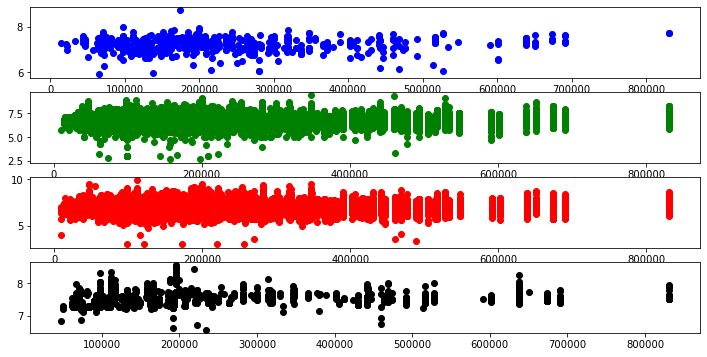

In [47]:
#建築年ごとの人口と価格の関係
mean1=sennzenn.groupby('計').mean()
mean2=syouwa.groupby('計').mean()
mean3=heisei.groupby('計').mean()
mean4=reiwa.groupby('計').mean()


fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

c1,c2,c3,c4 = "blue","green","red","black"      # 各プロットの色
l1,l2,l3,l4 = "戦前","昭和","平成","令和"   # 各ラベル

"""
ax1.bar(sennzenn['建築年'].unique(), mean1['取引価格（総額）_log'], color=c1, label=l1)
ax2.bar(syouwa['建築年'].unique(), mean2['取引価格（総額）_log'], color=c2, label=l2)
ax3.bar(heisei['建築年'].unique(), mean3['取引価格（総額）_log'], color=c3, label=l3)
ax4.bar(reiwa['建築年'].unique(), mean4['取引価格（総額）_log'], color=c4, label=l4)

"""


ax1.scatter(sennzenn['計'], sennzenn['取引価格（総額）_log'], color=c1, label=l1)
ax2.scatter(syouwa['計'], syouwa['取引価格（総額）_log'], color=c2, label=l2)
ax3.scatter(heisei['計'], heisei['取引価格（総額）_log'], color=c3, label=l3)
ax4.scatter(reiwa['計'], reiwa['取引価格（総額）_log'], color=c4, label=l4)


plt.show()

In [48]:
sennzenn=sennzenn.drop('市区町村名',axis=1)
syouwa=syouwa.drop('市区町村名',axis=1)
heisei=heisei.drop('市区町村名',axis=1)
reiwa=reiwa.drop('市区町村名',axis=1)

sennzenn.shape, syouwa.shape, heisei.shape, reiwa.shape

((565, 5), (208896, 5), (480825, 5), (1612, 5))

In [49]:
syouwa.loc[25294,'面積（㎡）'] = '2000'
syouwa.loc[46361,'面積（㎡）'] = '2000'
syouwa.loc[46425,'面積（㎡）'] = '2000'
syouwa.loc[65470,'面積（㎡）'] = '2000'

heisei.loc[16605,'面積（㎡）']='2000'
heisei.loc[24263,'面積（㎡）']='2000'
heisei.loc[89620,'面積（㎡）']='2000'
heisei.loc[228207,'面積（㎡）']='2000'
heisei.loc[309602,'面積（㎡）']='2000'

reiwa[reiwa['面積（㎡）']=='2000㎡以上']

,都道府県名,面積（㎡）,建築年,取引価格（総額）_log,計


In [50]:
heisei['面積（㎡）'].unique()

array([60, 65, 20, 25, 70, 40, 75, 15, 30, 80, 35, 85, 105, 50, 55, 95,
       10, 45, 330, 90, 100, 115, 120, 110, 140, 125, 170, 150, 500, 130,
       180, 135, 145, 630, 220, 190, 210, 160, 165, 175, 155, 195, 400,
       440, 2000, 230, '2000', 320, 830, 300, 820, 270, 460, 310, 260,
       185, 200, 730, 240, 250, 680, 390, 600, 790, 340, 760, 650, 670,
       290, 370, 350, 610, 280, 780, 620, 1300, 800, 690, 410, 950, 1000,
       710, 970, 360, 900, 1100, 540, 940, 770, 990, 700, 550, 490, 470,
       580, 510, 450, 560, 860, 1500, 480, 1400, 520, 890, 380, 1200, 420],
      dtype=object)

In [51]:
sennzenn['面積（㎡）']=sennzenn['面積（㎡）'].astype(int)
syouwa['面積（㎡）']=syouwa['面積（㎡）'].astype(int)
heisei['面積（㎡）']=heisei['面積（㎡）'].astype(int)
reiwa['面積（㎡）']=reiwa['面積（㎡）'].astype(int)

In [52]:
#建築年ごとに分割したデータを結合して訓練用データとして扱う
train_all2=pd.concat([sennzenn,syouwa,heisei,reiwa])


In [53]:
train_all2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691898 entries, 0 to 1611
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   都道府県名         691898 non-null  object 
 1   面積（㎡）         691898 non-null  int64  
 2   建築年           691898 non-null  int64  
 3   取引価格（総額）_log  691898 non-null  float64
 4   計             691898 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 31.7+ MB


In [54]:
#都道府県名はダミー変数
train_all2=pd.get_dummies(train_all2)
train_all2

,面積（㎡）,建築年,取引価格（総額）_log,計,都道府県名_三重県,都道府県名_京都府,都道府県名_佐賀県,都道府県名_兵庫県,都道府県名_北海道,都道府県名_千葉県,...,都道府県名_群馬県,都道府県名_茨城県,都道府県名_長崎県,都道府県名_長野県,都道府県名_青森県,都道府県名_静岡県,都道府県名_香川県,都道府県名_高知県,都道府県名_鳥取県,都道府県名_鹿児島県
0,85,1945,7.322219,162040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80,1945,7.278754,162040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65,1945,7.342423,162040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,65,1945,7.380211,162040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65,1945,7.380211,162040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,70,2020,7.732394,158426,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1608,70,2020,7.707570,158426,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1609,85,2020,7.799341,158426,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1610,80,2020,7.505150,590943,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#目的変数と説明変数の分割
train_x=train_all2.drop('取引価格（総額）_log', axis=1)
train_y=train_all2['取引価格（総額）_log']

In [92]:
#重回帰分析
#ランダムフォレスト
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#訓練検証データとテストデータに分割
trainval_x, test_x, trainval_y, test_y = train_test_split(train_x, train_y, test_size=0.3, random_state=1)

#訓練データと検証データに分割
train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.2, random_state=1)


#LinearRegressionインスタンス化
LR=LinearRegression()

#ハイパーパラメータ設定なし
LR.fit(train_x,train_y)

#精度確認
print('精度　', LR.score(train_x,train_y))
"""
#LinearRegressionインスタンス化
rfr=RandomForestRegressor()

#ハイパーパラメータ設定なし
rfr.fit(train_x,train_y)

#精度確認
print('精度　', rfr.score(train_x,train_y))
"""


精度　 0.5165333254612424


"\n#LinearRegressionインスタンス化\nrfr=RandomForestRegressor()\n\n#ハイパーパラメータ設定なし\nrfr.fit(train_x,train_y)\n\n#精度確認\nprint('精度\u3000', rfr.score(train_x,train_y))\n"

In [93]:
print('精度　', LR.score(val_x,val_y))

精度　 0.5612551351279631


In [104]:
np.mean(np.abs(val_y-LR.predict(val_x)))

0.17055977193654118

In [ ]:
print('精度　', rfr.score(val_x,val_y))

## テストデータで予測

In [58]:
#テストデータ読み込み
test=pd.read_csv('./data/test.csv')
#提出用サンプルファイル読み込み
sample=pd.read_csv('./data/sample_submission.csv')

In [59]:
test.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等'],
      dtype='object')

In [60]:
test['間取り'].unique()

array(['３ＬＤＫ', '１ＤＫ', '２ＬＤＫ', '４ＬＤＫ', '１ＬＤＫ', '１Ｒ', '１Ｋ', nan, 'オープンフロア',
       '２ＤＫ', '１ＬＤＫ＋Ｓ', '３ＤＫ', '４ＬＤＫ＋Ｓ', '３ＬＤＫ＋Ｓ', '５ＬＤＫ', '２ＬＤＫ＋Ｓ',
       '１ＤＫ＋Ｓ', '４Ｋ', '３Ｋ', '４ＤＫ', '２ＤＫ＋Ｓ', '４ＤＫ＋Ｓ', '２Ｋ', '３ＬＫ', 'メゾネット',
       '１ＬＫ', 'スタジオ', '３ＤＫ＋Ｓ', '２ＬＤ＋Ｓ', '５ＤＫ'], dtype=object)

In [61]:
test['都市計画'].unique()

array(['商業地域', '近隣商業地域', '第１種中高層住居専用地域', '準工業地域', '第２種住居地域', '第１種住居地域',
       '第２種中高層住居専用地域', '準住居地域', '第１種低層住居専用地域', '工業地域', '工業専用地域', nan,
       '都市計画区域外', '市街化調整区域', '第２種低層住居専用地域', '市街化区域及び市街化調整区域外の都市計画区域'],
      dtype=object)

In [62]:
test['今後の利用目的'].unique()

array(['住宅', '事務所', nan, 'その他', '店舗'], dtype=object)

In [63]:
test['建築年'].head(10)

0    平成28年
1    昭和52年
2    昭和59年
3    昭和64年
4     平成3年
5    昭和56年
6    昭和56年
7    昭和61年
8     平成2年
9     平成3年
Name: 建築年, dtype: object

In [64]:
#欠損値の多い列の削除
_Data=Delete_Null_Data(test)
test=_Data.delete_null_columns()
test.shape

(21005, 19)

In [65]:
test.columns

Index(['ID', '種類', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '間取り', '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装'],
      dtype='object')

In [66]:
test['建築年'].unique()

array(['平成28年', '昭和52年', '昭和59年', '昭和64年', '平成3年', '昭和56年', '昭和61年',
       '平成2年', '平成26年', '平成16年', '令和2年', '昭和49年', '平成31年', '平成19年',
       '昭和53年', '昭和58年', '昭和57年', '平成27年', '昭和60年', '平成18年', '平成4年',
       '平成14年', '平成17年', '平成30年', '平成25年', '平成15年', '平成8年', '平成11年',
       '昭和63年', '平成29年', '平成5年', '平成10年', '平成21年', '平成12年', '平成7年',
       '昭和54年', '平成6年', '昭和51年', '平成13年', '平成24年', '昭和44年', '平成9年',
       '昭和48年', '昭和46年', '昭和55年', nan, '昭和62年', '昭和39年', '令和3年', '平成22年',
       '平成20年', '昭和50年', '昭和47年', '平成23年', '戦前', '昭和45年', '昭和42年',
       '昭和41年', '昭和43年', '令和4年', '昭和40年', '昭和37年', '昭和29年', '昭和23年',
       '昭和30年'], dtype=object)

In [67]:
test=test[['都道府県名','市区町村名','面積（㎡）','建築年']]
print(test.columns)
print(test.info())

Index(['都道府県名', '市区町村名', '面積（㎡）', '建築年'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21005 entries, 0 to 21004
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   都道府県名   21005 non-null  object
 1   市区町村名   21005 non-null  object
 2   面積（㎡）   21005 non-null  int64 
 3   建築年     20404 non-null  object
dtypes: int64(1), object(3)
memory usage: 656.5+ KB
None


In [68]:
#欠損値を補完
test['建築年']=test['建築年'].fillna('null')

In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21005 entries, 0 to 21004
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   都道府県名   21005 non-null  object
 1   市区町村名   21005 non-null  object
 2   面積（㎡）   21005 non-null  int64 
 3   建築年     21005 non-null  object
dtypes: int64(1), object(3)
memory usage: 656.5+ KB


In [70]:
l.clear()

NameError: name 'l' is not defined

In [71]:
#インスタンス化、変換した西暦をカラムとして扱う

import numpy as np
import random

l=[]

y=test['建築年']

for i in range(0,len(y),1):
#for i in range(0,10):
    if y.iloc[i][:2]=='令和':
        if y.iloc[i][3]=='年':
            year=2018+int(y.iloc[i][2]) 
        else:
            year=2018+int(y.iloc[i][2])*10+int(y.iloc[i][3]) 
        l.append(year)
            
    elif y.iloc[i][:2]=='平成':
        if y.iloc[i][3]=='年':
            year=1988+int(y.iloc[i][2])
        else:
            year=1988+int(y.iloc[i][2])*10+int(y.iloc[i][3]) 
        l.append(year)
        
    elif y.iloc[i][:2]=='昭和':
        if y.iloc[i][3]=='年':
            year=1925+int(y.iloc[i][2])
        else:
            year=1925+int(y.iloc[i][2])*10+int(y.iloc[i][3]) 
        l.append(year)
        
    elif y.iloc[i][:2]=='戦前':
        year=1945
        l.append(year)
        
    else:
        year=random.randint(1931, 2021)
        l.append(year)


In [72]:
test['建築年']=l
test['建築年']

0        2016
1        1977
2        1984
3        1989
4        1991
         ... 
21000    1995
21001    1994
21002    2017
21003    2007
21004    2010
Name: 建築年, Length: 21005, dtype: int64

In [73]:
test.head(600)

,都道府県名,市区町村名,面積（㎡）,建築年
0,北海道,札幌市中央区,75,2016
1,北海道,札幌市中央区,30,1977
2,北海道,札幌市中央区,70,1984
3,北海道,札幌市中央区,50,1989
4,北海道,札幌市中央区,45,1991
...,...,...,...,...
595,北海道,函館市,20,1989
596,北海道,函館市,20,1989
597,北海道,札幌市清田区,65,1994
598,北海道,札幌市清田区,90,1996


In [74]:
population

,計,市区町村名
0,5543556,北海道
1,1884939,札幌市
2,206252,札幌市中央区
3,273577,札幌市北区
4,252688,札幌市東区
...,...,...
2332,1339,宮古郡
2333,1339,宮古郡多良間村
2334,5577,八重山郡
2335,4010,八重山郡竹富町


In [75]:
set(population['市区町村名'])-set(test['市区町村名'])

{'安房郡鋸南町',
 '瑞穂市',
 '利根郡川場村',
 '葦北郡',
 '小美玉市',
 '小田郡矢掛町',
 '黒川郡',
 '十和田市',
 '島根県',
 '北諸県郡三股町',
 '加美郡',
 '遠賀郡芦屋町',
 '島尻郡八重瀬町',
 '加古郡播磨町',
 '東置賜郡川西町',
 '枝幸郡浜頓別町',
 '上閉伊郡大槌町',
 '北足立郡',
 '北葛城郡',
 '河沼郡柳津町',
 '串間市',
 '佐伯市',
 '幡豆郡',
 '久世郡',
 '三戸郡新郷村',
 '中新川郡',
 '上益城郡甲佐町',
 '阿蘇郡産山村',
 '広尾郡大樹町',
 '富山県',
 '羽島市',
 '栗原市',
 '上川郡剣淵町',
 '青ヶ島村',
 '最上郡大蔵村',
 '榛原郡',
 '岩美郡岩美町',
 '加茂市',
 '加茂郡',
 '前原市',
 '空知郡南富良野町',
 '八女市',
 '雨竜郡北竜町',
 '西津軽郡鰺ヶ沢町',
 '野洲市',
 '神埼郡',
 '網走郡美幌町',
 '足柄上郡',
 '勢多郡富士見村',
 '北津軽郡鶴田町',
 '北葛飾郡鷲宮町',
 '西置賜郡小国町',
 '糟屋郡宇美町',
 '鶴ヶ島市',
 '藤津郡太良町',
 '上山市',
 '安芸郡安田町',
 '夷隅郡大多喜町',
 '西臼杵郡高千穂町',
 '紫波郡紫波町',
 '中頭郡読谷村',
 '山陽小野田市',
 '球磨郡あさぎり町',
 '男鹿市',
 '根室市',
 '下高井郡木島平村',
 '三方上中郡',
 '安芸郡東洋町',
 '西村山郡河北町',
 '虻田郡豊浦町',
 '菊池郡大津町',
 '岩出市',
 '下新川郡朝日町',
 '関市',
 '笠岡市',
 '南都留郡富士河口湖町',
 '田村郡小野町',
 '遠田郡美里町',
 '南都留郡鳴沢村',
 '名護市',
 '玉名郡',
 '幌泉郡えりも町',
 '美馬郡つるぎ町',
 '熊本県',
 '小矢部市',
 '西松浦郡有田町',
 '香南市',
 '武雄市',
 '利根郡片品村',
 '南津軽郡大鰐町',
 'みどり市',
 '豊岡市',
 '越智郡上島町',
 '久慈郡',
 '生駒郡安堵町',
 '玖珂郡和木町',
 '足柄上郡大井町',
 '京都郡みやこ町',
 '丹生郡'

In [76]:
tt=test['市区町村名'].unique()

In [77]:
pp=population['市区町村名'].unique()

In [78]:
diff=pd.DataFrame({
    '計': [87650, 6278, 148648, 314087, 165877, 187502, 139833, 130829, 189524, 91177, 52430, 274308, 283176, 169176, 61500, 69940],

    '市区町村名' : ['あま市',
                             'みよし市',
                             '岡山市中区',
                             '岡山市北区',
                             '岡山市南区',
                             '熊本市中央区',
                             '熊本市北区',
                             '熊本市南区',
                             '熊本市東区',
                             '熊本市西区',
                             '白岡市',
                             '相模原市中央区',
                             '相模原市南区',
                             '相模原市緑区',
                             '長久手市',
                             '鶴ケ島市']
})

In [79]:
population=pd.concat([population,diff])

In [80]:
#test=pd.merge(test,population,how='left', on='市区町村名')
p.clear()

NameError: name 'p' is not defined

In [81]:
#testデータに人口データより人口カラムを追加
p=[]

for i in range(len(test)):
    for j in range(len(population)):
        if test['市区町村名'].iloc[i]==population['市区町村名'].iloc[j]:
            p.append(population['計'].iloc[j])
            break
            
            
            
    #if flag==0 and test['市区町村名'].iloc[i]!=population['市区町村名'].iloc[j]:
        #p.append(np.mean(p))

In [82]:
test['市区町村名'], population['市区町村名']

(0        札幌市中央区
 1        札幌市中央区
 2        札幌市中央区
 3        札幌市中央区
 4        札幌市中央区
           ...  
 21000       浦添市
 21001       沖縄市
 21002       沖縄市
 21003       那覇市
 21004       那覇市
 Name: 市区町村名, Length: 21005, dtype: object,
 0         北海道
 1         札幌市
 2      札幌市中央区
 3       札幌市北区
 4       札幌市東区
        ...   
 11    相模原市中央区
 12     相模原市南区
 13     相模原市緑区
 14       長久手市
 15       鶴ケ島市
 Name: 市区町村名, Length: 2353, dtype: object)

In [83]:
len(test), len(p)

(21005, 21005)

In [84]:
test.isnull().sum()

都道府県名    0
市区町村名    0
面積（㎡）    0
建築年      0
dtype: int64

In [85]:
test['計']=p
test

,都道府県名,市区町村名,面積（㎡）,建築年,計
0,北海道,札幌市中央区,75,2016,206252
1,北海道,札幌市中央区,30,1977,206252
2,北海道,札幌市中央区,70,1984,206252
3,北海道,札幌市中央区,50,1989,206252
4,北海道,札幌市中央区,45,1991,206252
...,...,...,...,...,...
21000,沖縄県,浦添市,80,1995,110285
21001,沖縄県,沖縄市,55,1994,133762
21002,沖縄県,沖縄市,65,2017,133762
21003,沖縄県,那覇市,80,2007,314031


In [86]:
test_x=test.drop('市区町村名',axis=1)

In [87]:
test_x

,都道府県名,面積（㎡）,建築年,計
0,北海道,75,2016,206252
1,北海道,30,1977,206252
2,北海道,70,1984,206252
3,北海道,50,1989,206252
4,北海道,45,1991,206252
...,...,...,...,...
21000,沖縄県,80,1995,110285
21001,沖縄県,55,1994,133762
21002,沖縄県,65,2017,133762
21003,沖縄県,80,2007,314031


In [88]:
test_x=pd.get_dummies(test_x)

In [89]:
train_x.shape, test_x.shape

((387462, 50), (21005, 50))

In [90]:
test_x.head()

,面積（㎡）,建築年,計,都道府県名_三重県,都道府県名_京都府,都道府県名_佐賀県,都道府県名_兵庫県,都道府県名_北海道,都道府県名_千葉県,都道府県名_和歌山県,...,都道府県名_群馬県,都道府県名_茨城県,都道府県名_長崎県,都道府県名_長野県,都道府県名_青森県,都道府県名_静岡県,都道府県名_香川県,都道府県名_高知県,都道府県名_鳥取県,都道府県名_鹿児島県
0,75,2016,206252,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,1977,206252,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,70,1984,206252,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,1989,206252,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,45,1991,206252,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
#ランダムフォレスト実装、予測
#y=rfr.predict(test_x)
y=LR.predict(test_x)


In [100]:
len(y)

116239

In [97]:
#提出用サンプルファイル読み込み
sample=pd.read_csv('./data/sample_submission.csv')

In [98]:
sample.head()

,ID,取引価格（総額）_log
0,1000078,0
1,1000121,0
2,1000123,0
3,1000127,0
4,1000129,0


In [99]:
sample['取引価格（総額）_log']=y

ValueError: Length of values (116239) does not match length of index (21005)

In [ ]:
sample.head()

In [654]:
sample.to_csv('submission1.csv', index=None)

In [653]:
sample.shape

(21005, 2)

,都道府県名,市区町村名,面積（㎡）,建築年,計
0,北海道,札幌市中央区,75,2016,206252
1,北海道,札幌市中央区,30,1977,206252
2,北海道,札幌市中央区,70,1984,206252
3,北海道,札幌市中央区,50,1989,206252
4,北海道,札幌市中央区,45,1991,206252
...,...,...,...,...,...
21000,沖縄県,浦添市,80,1995,110285
21001,沖縄県,沖縄市,55,1994,133762
21002,沖縄県,沖縄市,65,2017,133762
21003,沖縄県,那覇市,80,2007,314031


In [665]:
test_x.to_csv('population_test.csv',columns='計')

## LightGBM

In [666]:
import lightgbm as lgb

trains = lgb.Dataset(train_x, train_y)
valids = lgb.Dataset(val_x, val_y)

params = {
    "objective": "regression",
    "metrics": "mae"
}

model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, early_stopping_rounds=100)

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 216978, number of used features: 49
[LightGBM] [Info] Start training from score 7.233081
[1]	valid_0's l1: 0.252657
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.236767
[3]	valid_0's l1: 0.222913
[4]	valid_0's l1: 0.211035
[5]	valid_0's l1: 0.200792
[6]	valid_0's l1: 0.191969
[7]	valid_0's l1: 0.184346
[8]	valid_0's l1: 0.17785
[9]	valid_0's l1: 0.172226
[10]	valid_0's l1: 0.167506
[11]	valid_0's l1: 0.163368
[12]	valid_0's l1: 0.159756
[13]	valid_0's l1: 0.156606
[14]	valid_0's l1: 0.153924
[15]	valid_0's l1: 0.151697
[16]	valid_0's l1: 0.149653
[17]	valid_0's l1: 0.147957
[18]	valid_0's l1: 0.146319
[19]	valid_0's l1: 0.144833
[20]	va

[294]	valid_0's l1: 0.108078
[295]	valid_0's l1: 0.108005
[296]	valid_0's l1: 0.107992
[297]	valid_0's l1: 0.107992
[298]	valid_0's l1: 0.107979
[299]	valid_0's l1: 0.107972
[300]	valid_0's l1: 0.107924
[301]	valid_0's l1: 0.107916
[302]	valid_0's l1: 0.107914
[303]	valid_0's l1: 0.107901
[304]	valid_0's l1: 0.107899
[305]	valid_0's l1: 0.107885
[306]	valid_0's l1: 0.107867
[307]	valid_0's l1: 0.107857
[308]	valid_0's l1: 0.107824
[309]	valid_0's l1: 0.107795
[310]	valid_0's l1: 0.10778
[311]	valid_0's l1: 0.107761
[312]	valid_0's l1: 0.10775
[313]	valid_0's l1: 0.107743
[314]	valid_0's l1: 0.107728
[315]	valid_0's l1: 0.107709
[316]	valid_0's l1: 0.107702
[317]	valid_0's l1: 0.107692
[318]	valid_0's l1: 0.107682
[319]	valid_0's l1: 0.107677
[320]	valid_0's l1: 0.107665
[321]	valid_0's l1: 0.107661
[322]	valid_0's l1: 0.107653
[323]	valid_0's l1: 0.107648
[324]	valid_0's l1: 0.107636
[325]	valid_0's l1: 0.107615
[326]	valid_0's l1: 0.107611
[327]	valid_0's l1: 0.107592
[328]	valid_0's 

[609]	valid_0's l1: 0.105195
[610]	valid_0's l1: 0.105195
[611]	valid_0's l1: 0.105187
[612]	valid_0's l1: 0.105178
[613]	valid_0's l1: 0.105155
[614]	valid_0's l1: 0.105153
[615]	valid_0's l1: 0.105152
[616]	valid_0's l1: 0.105144
[617]	valid_0's l1: 0.105134
[618]	valid_0's l1: 0.105126
[619]	valid_0's l1: 0.105115
[620]	valid_0's l1: 0.105112
[621]	valid_0's l1: 0.105113
[622]	valid_0's l1: 0.105113
[623]	valid_0's l1: 0.105105
[624]	valid_0's l1: 0.105103
[625]	valid_0's l1: 0.105099
[626]	valid_0's l1: 0.105096
[627]	valid_0's l1: 0.105095
[628]	valid_0's l1: 0.105095
[629]	valid_0's l1: 0.105091
[630]	valid_0's l1: 0.105075
[631]	valid_0's l1: 0.105066
[632]	valid_0's l1: 0.105053
[633]	valid_0's l1: 0.105047
[634]	valid_0's l1: 0.105033
[635]	valid_0's l1: 0.105025
[636]	valid_0's l1: 0.105014
[637]	valid_0's l1: 0.10501
[638]	valid_0's l1: 0.104995
[639]	valid_0's l1: 0.104993
[640]	valid_0's l1: 0.104992
[641]	valid_0's l1: 0.104989
[642]	valid_0's l1: 0.104989
[643]	valid_0's

[920]	valid_0's l1: 0.103857
[921]	valid_0's l1: 0.103853
[922]	valid_0's l1: 0.103852
[923]	valid_0's l1: 0.103844
[924]	valid_0's l1: 0.103842
[925]	valid_0's l1: 0.103841
[926]	valid_0's l1: 0.103837
[927]	valid_0's l1: 0.103833
[928]	valid_0's l1: 0.103825
[929]	valid_0's l1: 0.103822
[930]	valid_0's l1: 0.103816
[931]	valid_0's l1: 0.103814
[932]	valid_0's l1: 0.103802
[933]	valid_0's l1: 0.103797
[934]	valid_0's l1: 0.103797
[935]	valid_0's l1: 0.103797
[936]	valid_0's l1: 0.103797
[937]	valid_0's l1: 0.103796
[938]	valid_0's l1: 0.103795
[939]	valid_0's l1: 0.103786
[940]	valid_0's l1: 0.103785
[941]	valid_0's l1: 0.103781
[942]	valid_0's l1: 0.103779
[943]	valid_0's l1: 0.103778
[944]	valid_0's l1: 0.103773
[945]	valid_0's l1: 0.103765
[946]	valid_0's l1: 0.103762
[947]	valid_0's l1: 0.103761
[948]	valid_0's l1: 0.103756
[949]	valid_0's l1: 0.10375
[950]	valid_0's l1: 0.103745
[951]	valid_0's l1: 0.103749
[952]	valid_0's l1: 0.103745
[953]	valid_0's l1: 0.103738
[954]	valid_0's

In [668]:
train_x

,面積（㎡）,建築年,計,都道府県名_三重県,都道府県名_京都府,都道府県名_佐賀県,都道府県名_兵庫県,都道府県名_北海道,都道府県名_千葉県,都道府県名_和歌山県,...,都道府県名_群馬県,都道府県名_茨城県,都道府県名_長崎県,都道府県名_長野県,都道府県名_青森県,都道府県名_静岡県,都道府県名_香川県,都道府県名_高知県,都道府県名_鳥取県,都道府県名_鹿児島県
9910,115,1992,162040,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
425265,55,1994,638194,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
328365,15,2000,281783,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91122,15,1988,317483,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196784,105,1981,476813,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134074,55,1978,319267,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214394,75,2004,296840,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71296,85,1999,147571,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119187,40,1985,111132,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [669]:
y=model.predict(test_x)
sample['取引価格（総額）_log']=y

sample.to_csv('submission4.csv', index=None)

In [674]:
from scipy.special import comb

print(comb(100, 55)*(0.5**100))
# 6.0

print(comb(4, 2, exact=True))
# 6

0.04847429662643074
6


In [675]:
(169.4-170)/1.2, (172.4-170)/1.2

(-0.4999999999999953, 2.000000000000005)

In [676]:
(777-750)**2/750 + (223-250)**2/250

3.888